# **Import librairies**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.9.2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Load Data**

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
df = pd.read_csv('drive/MyDrive/training.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
#rename columns for my reference
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
#We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [6]:
#Decoding the labels. We map 0 -> Negative and 4 -> Positive as directed by the datset desciption

lab_to_sentiment = {0:"Negative", 4:"Positive"}

def label_decoder(label):
    return lab_to_sentiment[label]

df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

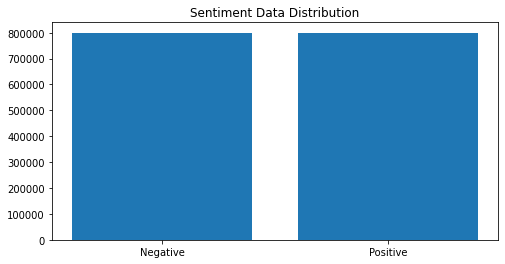

In [7]:
#Analysing dataset by its distribution

val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

## **Data Preprocessing**



In [8]:
#check missing data
df.isna().sum()

sentiment    0
text         0
dtype: int64

In [ ]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
692372,Negative,Luggage still lost and not found...
88110,Negative,@NiceMac Some of us actually wanted to WATCH t...
1285695,Positive,"@Bambiebaybe hahaha! And um, why in da hell i..."
700126,Negative,Goodness I am tired... Ugh lack of sleep is so...
1285055,Positive,Woo Woo ... just landed job as Top Shop Manage...
1252555,Positive,@Hanssie well maybe we should price plane tick...
1178676,Positive,I might go on my trampoline not been on it in...
934688,Positive,@danielle5572 there is no other way! I'm very ...
691880,Negative,"@gemery8 only seen the film, really really goo..."
1247141,Positive,@holycowirock Me too. Shh...don't tell anyone.


# **Text Preprocessing**

In [9]:
#Remove URL

def remove_url(text):
    urlfree=re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    return urlfree 
df['text']= df['text'].apply(lambda x:remove_url(x))
df.head()

,sentiment,text
0,Negative,@switchfoot - A that's a bummer. You shoulda...
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [10]:
#Remove mentions

def remove_mention(text):
    mentionfree=re.sub(r'\@\w+|\#','', text)
    return mentionfree 
df['text']= df['text'].apply(lambda x:remove_mention(x))
df.head()

,sentiment,text
0,Negative,- A that's a bummer. You shoulda got David ...
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,I dived many times for the ball. Managed to s...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"no, it's not behaving at all. i'm mad. why am..."


In [11]:
#Lower Casing

df['text']= df['text'].apply(lambda x: x.lower())
df.head()

,sentiment,text
0,Negative,- a that's a bummer. you shoulda got david ...
1,Negative,is upset that he can't update his facebook by ...
2,Negative,i dived many times for the ball. managed to s...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"no, it's not behaving at all. i'm mad. why am..."


In [12]:
#Remove stopwords
def remove_stopwords(text):
    stopwordsfree=" ".join([word for word in str(text).split() if word not in stop_words])
    return stopwordsfree 
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
df.head()

,sentiment,text
0,Negative,- that's bummer. shoulda got david carr third ...
1,Negative,upset can't update facebook texting it... migh...
2,Negative,dived many times ball. managed save 50% rest g...
3,Negative,whole body feels itchy like fire
4,Negative,"no, behaving all. i'm mad. here? can't see there."


In [13]:
import string
#Remove punctuations

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
df['text']= df['text'].apply(lambda x:remove_punctuation(x))
df.head()

,sentiment,text
0,Negative,thats bummer shoulda got david carr third day...
1,Negative,upset cant update facebook texting it might cr...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,no behaving all im mad here cant see there


In [14]:
#Remove numbers

def non_num(text):
    nonnum=re.sub(r'\d+', '', text)
    return nonnum 
df['text']= df['text'].apply(lambda x:non_num(x))
df.head()

,sentiment,text
0,Negative,thats bummer shoulda got david carr third day...
1,Negative,upset cant update facebook texting it might cr...
2,Negative,dived many times ball managed save rest go bo...
3,Negative,whole body feels itchy like fire
4,Negative,no behaving all im mad here cant see there


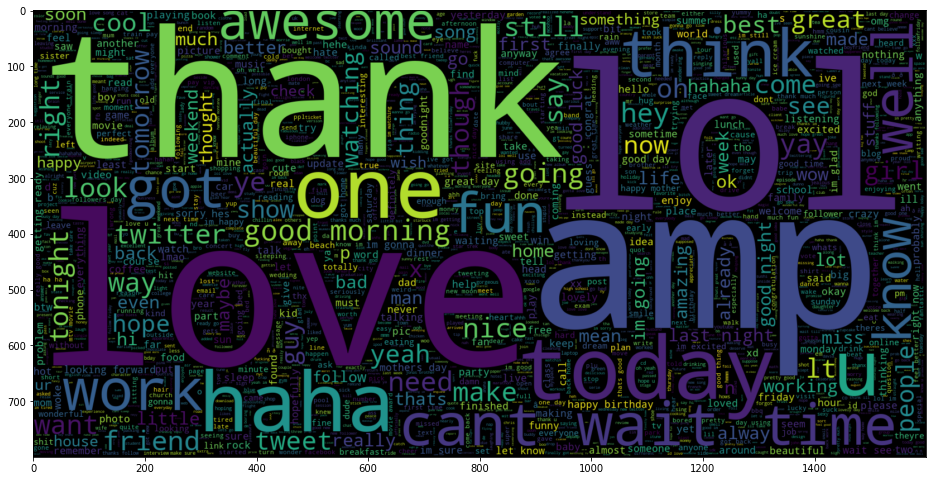

In [ ]:
#cloud visualization of positive word 

from wordcloud import WordCloud
plt.figure(figsize = (16,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

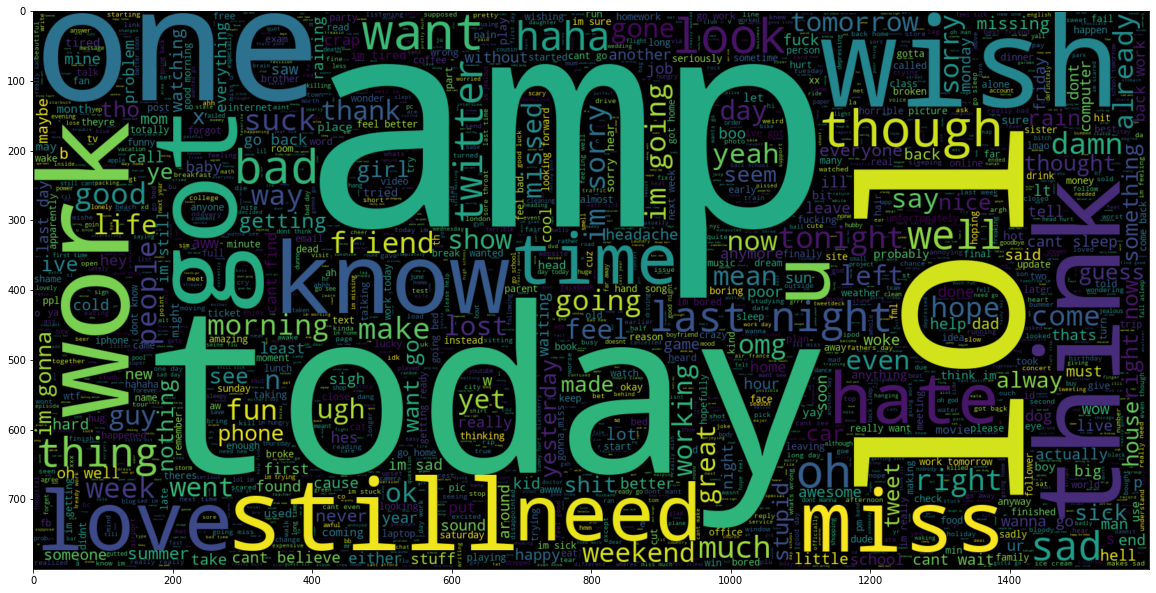

In [ ]:
#cloud visualization of negative word

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

# **Train/Test split**

In [15]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_train.head()
print(df_train.shape)
print(df_test.shape)

(1120000, 2)
(480000, 2)


# **Tokenization**

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called *tokens* , perhaps at the same time throwing away certain characters, such as punctuation. The process is called Tokenization.

`tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.

`word_index` contains the index for each word

`vocab_size` represents the total number of word in the data corpus

In [ ]:
def fit_tokenizer(train_text, oov_token):
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_text)
    return tokenizer

tokenizer = fit_tokenizer(df_train.text, oov_token='<OOV>')

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 334298


# **Sequences, Trunking and padding**

Now we got a `tokenizer` object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from `pad_sequence` to do our job. It will make all the sequence in one constant length `MAX_SEQUENCE_LENGTH`.

In [ ]:
EMBEDDING_DIM = 300
MAXLEN = 100
TRUNCATING = 'post'
PADDING = 'post'
lstm1_dim = 128
lstm2_dim = 64
filters = 128
kernel_size = 3

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def seq_pad_and_trunc(text, tokenizer, padding, truncating, maxlen):
    sequences = tokenizer.texts_to_sequences(text) #encoding text
    pad_trunc_sequences = pad_sequences(sequences,maxlen=maxlen, truncating=truncating,padding=padding)
    return pad_trunc_sequences

train_pad_trunc_seq = seq_pad_and_trunc(df_train.text, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(df_test.text, tokenizer, PADDING, TRUNCATING, MAXLEN)




In [ ]:
print("Training X Shape:",train_pad_trunc_seq.shape)
print("Testing X Shape:",val_pad_trunc_seq.shape)

Training X Shape: (1120000, 100)
Testing X Shape: (480000, 100)


# **Label Encoding**

We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [ ]:
lb = LabelEncoder()

train_labels = np.array(df_train.sentiment)
test_labels = np.array(df_test.sentiment)

y_train = lb.fit_transform(train_labels)
y_test = lb.fit_transform(test_labels)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1120000, 1)
y_test shape: (480000, 1)


# **Define and train Model**

This code defines a function called create_model() that creates a sequential neural network model using the TensorFlow library. The model takes three inputs: vocab_size, embedding_dim, and maxlen.

The model is composed of several layers:


1.   Embedding layer which takes vocab_size and embedding_dim as input and is used to convert the input to dense embedding of fixed size.
2.   A 1D convolutional layer with a filter size and kernel size specified by the filters and kernel_size variables (which are not defined in this code snippet) and uses the ReLU activation function.
3.  Two bidirectional LSTM layers with dimensions specified by the lstm1_dim and lstm2_dim variables (which are also not defined in this code snippet) and return_sequences=True in the first layer.
4. Several dropout layers with a dropout rate of 0.3 to prevent overfitting
Several dense layers with different number of neurons and relu activation function.
5. The final dense layer with sigmoid activation function that outputs a probability between 0 and 1.







In [ ]:
def create_model(vocab_size, embedding_dim, maxlen):
    
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    

    model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy']) 
 

    return model
model = create_model(vocab_size, EMBEDDING_DIM, MAXLEN)
model.summary()
history = model.fit(train_pad_trunc_seq, y_train, epochs=4, validation_data=(val_pad_trunc_seq, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          100289400 
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           115328    
                                                                 
 bidirectional (Bidirectiona  (None, 98, 256)          263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

# **Evaluation of the model**

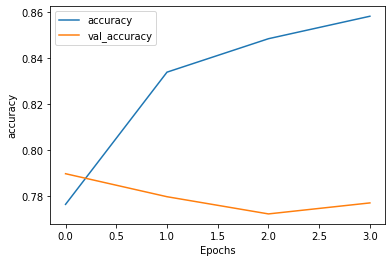

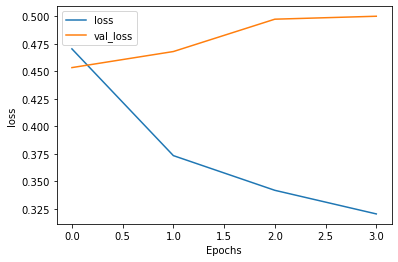

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as **POSITIVE** sentiment

In [ ]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(val_pad_trunc_seq, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

48/48 [==============================] - 28s 547ms/step


# **Confusion Matrix**

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

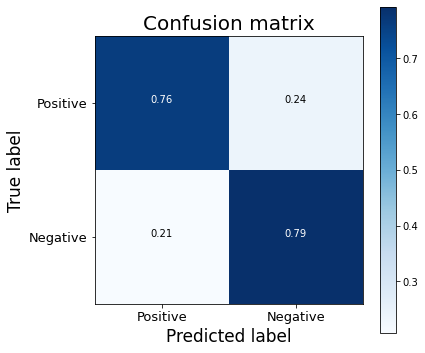

In [ ]:
cnf_matrix = confusion_matrix(df_test.sentiment.tolist(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.sentiment.unique(), title="Confusion matrix")
plt.show()

# **Classification report**

In [ ]:
print(classification_report(list(df_test.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.76      0.77    239361
    Positive       0.77      0.79      0.78    240639

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



It's a pretty good model we trained here in terms of NLP. Around 80% accuracy is good enough considering the baseline human accuracy also pretty low in these tasks. Also, you may go on and explore the dataset, some tweets might have other languages than English. So our Tokenizing wont have effect on them. But on practical scenario, this model is good for handling most tasks for Sentiment Analysis

# **Predict results**

In [ ]:
import time
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAXLEN)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict("I'm having a bad day")

1/1 [==============================] - 0s 35ms/step


{'label': 'Negative',
 'score': 0.48648157715797424,
 'elapsed_time': 0.06723237037658691}

In [ ]:
predict("Today I will finally make it")

1/1 [==============================] - 0s 33ms/step


{'label': 'Positive',
 'score': 0.6976280808448792,
 'elapsed_time': 0.07569098472595215}

# **Pretrained ROBERTA model**

In [16]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.0 MB/s eta 0:00:00


In [17]:
from transformers import TFAutoModel, AutoTokenizer
AUTO = tf.data.experimental.AUTOTUNE
MODEL = 'roberta-base'

In [18]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
#Tokenization

x_train = tokenizer(
    text = df_train['text'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

x_test = tokenizer(
    text = df_test['text'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [ ]:
transformer_layer = TFAutoModel.from_pretrained(MODEL)
model_roberta_base = build_model(transformer_layer, max_len=max_len)

In [ ]:
n_steps = X_train.shape[0] // batch_size
model_roberta_base.fit(train_dataset,steps_per_epoch=n_steps,validation_data=valid_dataset,epochs=Epoch)